# import data


#Using apache spark

In [1]:
# Download Spark
%pip install pyspark
%pip install findspark

#Install implicit
%pip install implicit
%pip install pandas
%pip install numpy
%pip install os
%pip install matplotlib
%pip install seaborn
%pip install jupyter
%pip install wget
%pip install unzip


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribu

In [2]:
import pandas as pd


In [3]:
import os
# Initialize findspark and create SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("BookRecommendation") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "2g") \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.bindAddress", "localhost") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/24 00:36:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark.sql.functions import count, col, when, mean, rand  # Import all at once

In [47]:
#Check if we have the data
# Check if data files exist
if os.path.exists('Users.csv') and os.path.exists('Books.csv') and os.path.exists('Ratings.csv'):
    print("Data files already exist")
    exit
else:
    # Import data from GitHub using wget
    !wget -O data.zip 'https://github.com/giahuy1310/bookrecommendation/raw/main/BookDataset.zip'
    !unzip data.zip
    # Load data into Spark DataFrame
users = spark.read.csv('Users.csv', header=True, inferSchema=True)
books = spark.read.csv('Books.csv', header = True, inferSchema=True)
ratings = spark.read.csv('Ratings.csv', header=True, inferSchema=True)


Data files already exist


In [48]:
# Show schemas
books.printSchema()
ratings.printSchema()
users.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)

root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)

root
 |-- User-ID: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)



In [49]:
# prompt:  change the type of the Age from string to float

from pyspark.sql.types import IntegerType

users = users.withColumn("Age", users["Age"].cast(IntegerType()))
users.printSchema()

books = books.withColumn("Year-Of-Publication", books["Year-Of-Publication"].cast(IntegerType()))
books.printSchema()


root
 |-- User-ID: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: integer (nullable = true)

root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: integer (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)



## EDA

In [50]:
books.describe().show()
users.describe().show()
ratings.describe().show()


+-------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|summary|                ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+-------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              271360|              271360|              271359|             271303|              271358|              271360|              271360|              271357|
|   mean|1.0412234356977516E9|            Infinity|              2001.0|  1959.754171535147|  3765.6153846153848|             1992.25|              1984.5|             1988.25|
| stddev|1.4877142833957229E9|                 NaN|  1.7320508075688772| 258.01944980678707|  7963.0591536808415|  

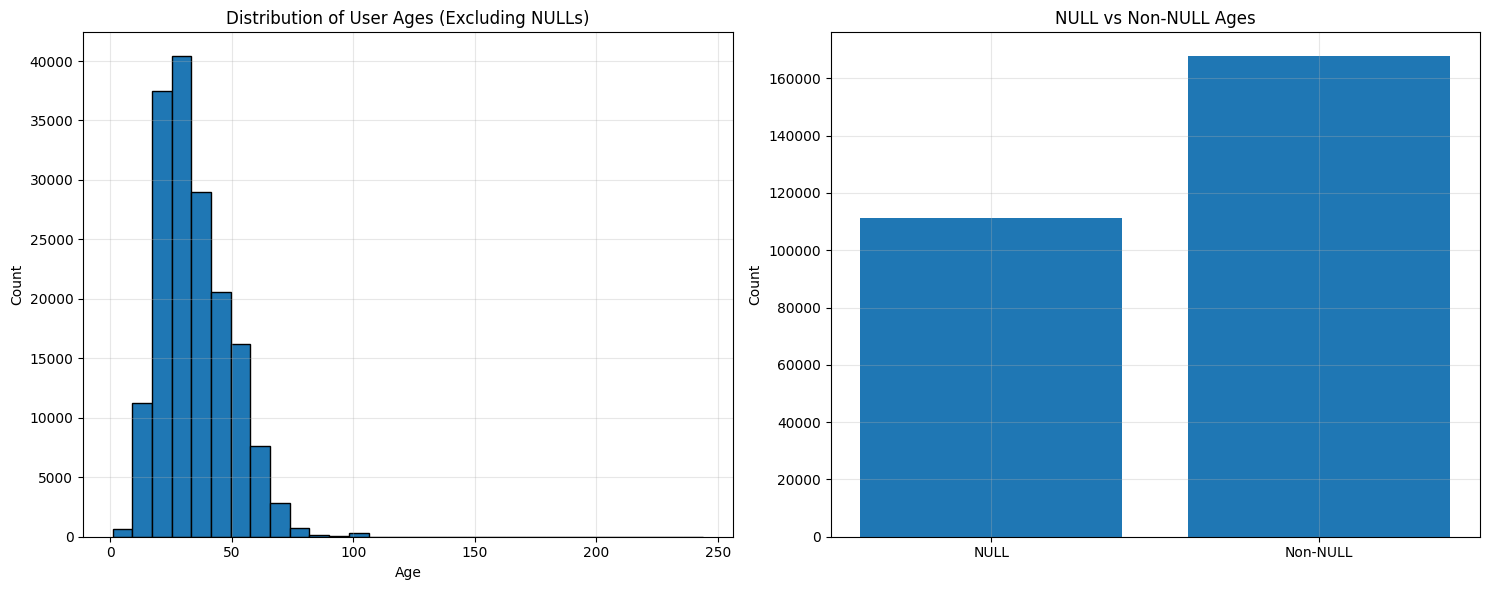


Detailed Age Statistics:
Total records: 278859
NULL ages: 111185
Non-NULL ages: 167674
Percentage of NULL ages: 39.87%

Age Statistics (excluding NULLs):
+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            167674|
|   mean|34.751833915812824|
| stddev|14.431010268447515|
|    min|                 0|
|    max|               244|
+-------+------------------+



In [52]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
# Create a figure with two subplots

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Plot 1: Age distribution (excluding NULLs)
age_data = users.select("Age").toPandas()
age_data = age_data.dropna()
age_data = age_data[age_data["Age"] > 0]
ax1.hist(age_data["Age"], bins=30, edgecolor='black')
ax1.set_title('Distribution of User Ages (Excluding NULLs)')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')
ax1.grid(True, alpha=0.3)

# Plot 2: NULL vs Non-NULL distribution
null_count = users.filter(col("Age").isNull()).count()
non_null_count = users.filter(col("Age").isNotNull()).count()
ax2.bar(['NULL', 'Non-NULL'], [null_count, non_null_count])
ax2.set_title('NULL vs Non-NULL Ages')
ax2.set_ylabel('Count')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

total_count = users.count()
# Print detailed statistics
print("\nDetailed Age Statistics:")
print(f"Total records: {users.count()}")
print(f"NULL ages: {null_count}")
print(f"Non-NULL ages: {non_null_count}")
print(f"Percentage of NULL ages: {(null_count/total_count)*100:.2f}%")

# Show age statistics for non-NULL values
print("\nAge Statistics (excluding NULLs):")
users.filter(col("Age").isNotNull()).select("Age").describe().show()

In [53]:
import matplotlib.pyplot as plt
# Filter users between 10 and 80 years old
print("Number of users before filtering:")
print(users.select("User-ID").distinct().count())
filtered_users = users.filter((users.Age.isNotNull() & (users.Age >= 10) & (users.Age <= 80)) | users.Age.isNull())

print("Number of users after filtering:")
print(filtered_users.select("User-ID").distinct().count())

print("Percentage of users filtered out:")
print(f"{(total_count - filtered_users.select('User-ID').distinct().count()) / total_count * 100:.2f}%")


Number of users before filtering:
278859
Number of users after filtering:
277205
Percentage of users filtered out:
0.59%


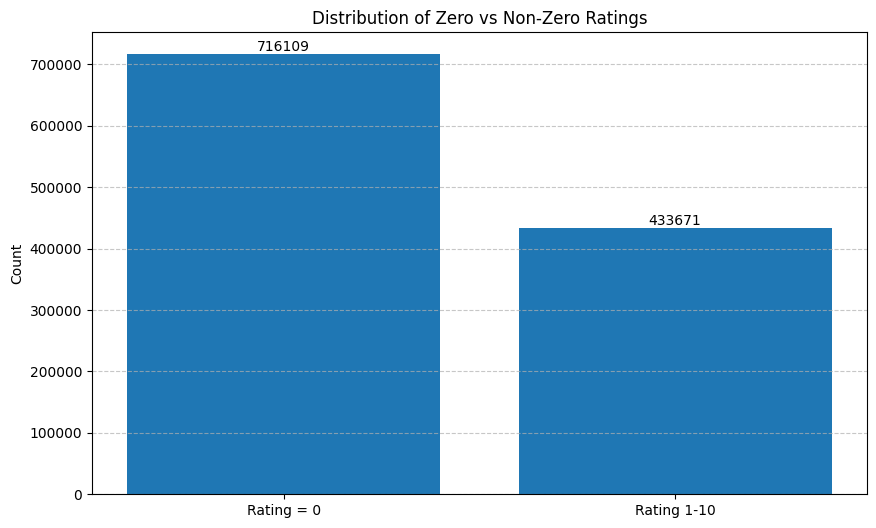

In [54]:
# Count ratings
zero_ratings = ratings.filter(ratings['Book-Rating'] == 0).count()
nonzero_ratings = ratings.filter(ratings['Book-Rating'] > 0).count()

# Create data for plotting
import matplotlib.pyplot as plt

rating_counts = [zero_ratings, nonzero_ratings]
labels = ['Rating = 0', 'Rating 1-10']

# Create bar plot
plt.figure(figsize=(10,6))
plt.bar(labels, rating_counts)
plt.title('Distribution of Zero vs Non-Zero Ratings')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(rating_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()


In [55]:
# Check for null values in users DataFrame
print("Null values in users DataFrame:")
users.select([count(when(col(c).isNull(), c)).alias(c) for c in users.columns]).show()

# Check for null values in ratings DataFrame  
print("\nNull values in ratings DataFrame:")
ratings.select([count(when(col(c).isNull(), c)).alias(c) for c in ratings.columns]).show()

# Check for null values in books DataFrame
print("\nNull values in books DataFrame:") 
books.select([count(when(col(c).isNull(), c)).alias(c) for c in books.columns]).show()


Null values in users DataFrame:
+-------+--------+------+
|User-ID|Location|   Age|
+-------+--------+------+
|      1|       0|111185|
+-------+--------+------+


Null values in ratings DataFrame:
+-------+----+-----------+
|User-ID|ISBN|Book-Rating|
+-------+----+-----------+
|      0|   0|          0|
+-------+----+-----------+


Null values in books DataFrame:
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|ISBN|Book-Title|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|   0|         0|          1|                 57|        2|          0|          0|          3|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+



In [56]:
# Drop rows with null User-ID
users = users.dropna(subset=['User-ID'])
ratings = ratings.dropna(subset=['User-ID'])

# Drop null values in books DataFrame
books = books.dropna()

print("After dropping nulls:")
print("\nUsers count:", users.count())
print("Ratings count:", ratings.count()) 
print("Books count:", books.count())


After dropping nulls:

Users count: 278858
Ratings count: 1149780
Books count: 271300


In [57]:
# Check for null values in users DataFrame after processing
print("Null values in users DataFrame after processing:")
users.select([count(when(col(c).isNull(), c)).alias(c) for c in users.columns]).show()

# Check for null values in ratings DataFrame after processing
print("\nNull values in ratings DataFrame after processing:")
ratings.select([count(when(col(c).isNull(), c)).alias(c) for c in ratings.columns]).show()

# Check for null values in books DataFrame after processing
print("\nNull values in books DataFrame after processing:")
books.select([count(when(col(c).isNull(), c)).alias(c) for c in books.columns]).show()


Null values in users DataFrame after processing:
+-------+--------+------+
|User-ID|Location|   Age|
+-------+--------+------+
|      0|       0|111184|
+-------+--------+------+


Null values in ratings DataFrame after processing:
+-------+----+-----------+
|User-ID|ISBN|Book-Rating|
+-------+----+-----------+
|      0|   0|          0|
+-------+----+-----------+


Null values in books DataFrame after processing:
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|ISBN|Book-Title|Book-Author|Year-Of-Publication|Publisher|Image-URL-S|Image-URL-M|Image-URL-L|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+
|   0|         0|          0|                  0|        0|          0|          0|          0|
+----+----------+-----------+-------------------+---------+-----------+-----------+-----------+



In [58]:
print('Number of distinct users:', filtered_users.select('User-ID').distinct().count())
print('Number of distinct users in ratings:', ratings.select('User-ID').distinct().count())

Number of distinct users: 277205
Number of distinct users in ratings: 105283


In [59]:
check_users = filtered_users.join(ratings, 'User-ID', 'inner')
print('Number of distinct users in ratings:', check_users.select('User-ID').distinct().count())

Number of distinct users in ratings: 104634


In [76]:
check_book = ratings.join(books, 'ISBN', 'inner')
print('Number of distinct users in ratings:', check_book.select('User-ID').distinct().count())

Number of distinct users in ratings: 91548


In [77]:
check_total = check_users.join(check_book, 'User-ID', 'inner')
print('Number of distinct users in ratings:', check_total.select('User-ID').distinct().count())

Number of distinct users in ratings: 91548


In [60]:
# Keep only ratings from users that exist in filtered_users
print("Ratings count before filtering:", ratings.count())
ratings = ratings.join(filtered_users.select("User-ID"), "User-ID", "inner")

print("Ratings count after filtering:", ratings.count())


Ratings count before filtering: 1149780
Ratings count after filtering: 1139222


## Xử lý users


In [74]:
# Step 1: Data Cleaning - Convert Year-Of-Publication to integer
from pyspark.sql.functions import col, when, avg, stddev, mean, median
from pyspark.sql.types import IntegerType

# Step 2: Join books with ratings to get user reading history
user_book_history = ratings.join(books, "ISBN", 'inner')

# Step 3: Calculate numerical features from Year-Of-Publication
user_numerical_features = user_book_history.groupBy("User-ID").agg(
    mean("Year-Of-Publication").alias("mean_pub_year"),
    median("Year-Of-Publication").alias("median_pub_year"),
    stddev("Year-Of-Publication").alias("std_dev_pub_year")
)

# Step 4: Calculate target encoding for Book-Author
# First, get average age per author from users with known ages
author_age_mapping = user_book_history.join(filtered_users.filter(col("Age").isNotNull()), "User-ID") \
    .groupBy("Book-Author") \
    .agg(avg("Age").alias("author_encoded_age"))

# Apply author encoding to all books
books_with_author_encoding = books.join(author_age_mapping, "Book-Author", "left")

# Calculate mean author encoding per user
user_author_features = user_book_history.join(books_with_author_encoding, ["ISBN", "Book-Author"]) \
    .groupBy("User-ID") \
    .agg(mean("author_encoded_age").alias("mean_author_encoded_age"))

# Step 5: Calculate target encoding for Publisher
publisher_age_mapping = user_book_history.join(filtered_users.filter(col("Age").isNotNull()), "User-ID") \
    .groupBy("Publisher") \
    .agg(avg("Age").alias("publisher_encoded_age"))

# Apply publisher encoding to all books
books_with_publisher_encoding = books.join(publisher_age_mapping, "Publisher", "left")

# Calculate mean publisher encoding per user
user_publisher_features = user_book_history.join(books_with_publisher_encoding, ["ISBN", "Publisher"]) \
    .groupBy("User-ID") \
    .agg(mean("publisher_encoded_age").alias("mean_publisher_encoded_age"))

# Step 6: Combine all features
user_features = user_numerical_features \
    .join(user_author_features, "User-ID", "left") \
    .join(user_publisher_features, "User-ID", "left")

# Step 7: Join with original users DataFrame to get target variable (Age)
process_user_age = user_features.join(filtered_users.select("User-ID", "Age"), "User-ID", "left")

# Display the final feature set
print("Final feature set schema:")
process_user_age.printSchema()

print("\nSample of processed data:")
process_user_age.show(5)


Final feature set schema:
root
 |-- User-ID: integer (nullable = true)
 |-- mean_pub_year: double (nullable = true)
 |-- median_pub_year: double (nullable = true)
 |-- std_dev_pub_year: double (nullable = true)
 |-- mean_author_encoded_age: double (nullable = true)
 |-- mean_publisher_encoded_age: double (nullable = true)
 |-- Age: integer (nullable = true)


Sample of processed data:


+-------+------------------+---------------+------------------+-----------------------+--------------------------+----+
|User-ID|     mean_pub_year|median_pub_year|  std_dev_pub_year|mean_author_encoded_age|mean_publisher_encoded_age| Age|
+-------+------------------+---------------+------------------+-----------------------+--------------------------+----+
|     53|1990.5714285714287|         1992.0| 6.477065767180455|      42.33489304812834|         37.53558997111198|NULL|
|     78|            1988.0|         1988.0|              NULL|           32.572265625|         30.73865414710485|  18|
|     85|            2001.0|         2001.0|1.4142135623730951|                33.2375|          35.0144213318442|  41|
|    133|1991.6666666666667|         1991.0| 2.081665999466133|     41.549257105943155|         38.78149527887378|  45|
|    243| 1997.506329113924|         1999.0| 5.806436344135757|      38.51132047009556|         37.74714772981151|NULL|
+-------+------------------+------------

In [75]:
print(f"Number of distinct users: {process_user_age.select('User-ID').distinct().count()}")

Number of distinct users: 91548


In [78]:
# Check for null values in each column
from functools import reduce
print("Null value counts per column:")
for column in process_user_age.columns:
    null_count = process_user_age.filter(col(column).isNull()).count()
    print(f"{column}: {null_count} null values")

# Check total null values in the dataset
total_rows = process_user_age.count()
print(f"\nTotal rows in dataset: {total_rows}")

# Show sample of rows with null values
print("\nSample of rows containing null values:")
process_user_age.filter(
    reduce(lambda x, y: x | y, [col(c).isNull() for c in process_user_age.columns])
).show(5)


Null value counts per column:
User-ID: 0 null values
mean_pub_year: 0 null values
median_pub_year: 0 null values
std_dev_pub_year: 51003 null values


mean_author_encoded_age: 1551 null values


mean_publisher_encoded_age: 394 null values
Age: 38261 null values

Total rows in dataset: 91548

Sample of rows containing null values:


+-------+------------------+---------------+-----------------+-----------------------+--------------------------+----+
|User-ID|     mean_pub_year|median_pub_year| std_dev_pub_year|mean_author_encoded_age|mean_publisher_encoded_age| Age|
+-------+------------------+---------------+-----------------+-----------------------+--------------------------+----+
|     53|1990.5714285714287|         1992.0|6.477065767180455|      42.33489304812834|         37.53558997111198|NULL|
|     78|            1988.0|         1988.0|             NULL|           32.572265625|         30.73865414710485|  18|
|    243| 1997.506329113924|         1999.0|5.806436344135757|      38.51132047009556|         37.74714772981151|NULL|
|    463|            1995.0|         1995.0|             NULL|     25.023255813953487|                      24.0|  20|
|    472|            1993.0|         1994.5|5.291502622129182|     36.395833333333336|         38.68284521048285|NULL|
+-------+------------------+---------------+----

In [79]:
# Fill null values with median for all columns except 'Age'
from pyspark.sql.functions import col, when, lit
from pyspark.sql.types import DoubleType

# Get median values for each column
median_values = {}
for column in process_user_age.columns:
    if column not in ['User-ID', 'Age']:  # Skip User-ID and Age columns
        median = process_user_age.approxQuantile(column, [0.5], 0.01)[0]
        median_values[column] = median

# Fill null values with median for each column
for column, median in median_values.items():
    process_user_age = process_user_age.withColumn(
        column,
        when(col(column).isNull(), lit(median)).otherwise(col(column))
    )

# Verify null values after filling
print("Null value counts after filling:")
for column in process_user_age.columns:
    null_count = process_user_age.filter(col(column).isNull()).count()
    print(f"{column}: {null_count} null values")


Null value counts after filling:
User-ID: 0 null values


mean_pub_year: 0 null values
median_pub_year: 0 null values
std_dev_pub_year: 0 null values


mean_author_encoded_age: 0 null values


mean_publisher_encoded_age: 0 null values
Age: 38261 null values


In [71]:
process_user_age.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------------+--------------------------+------------------+
|summary|           User-ID|     mean_pub_year|   median_pub_year|  std_dev_pub_year|mean_author_encoded_age|mean_publisher_encoded_age|               Age|
+-------+------------------+------------------+------------------+------------------+-----------------------+--------------------------+------------------+
|  count|            104634|            104634|            104634|            104634|                 104634|                    104634|             61375|
|   mean|139442.46466731656|1955.1148970907436|1964.2142276888965| 35.86704806505941|      36.83156003964847|         36.89414034152192|35.414680244399186|
| stddev| 80572.10163891372|247.33460738749793|243.18239465203797|160.71176619655324|      4.423747347362032|         2.818338502241186|13.606569703385862|
|    min|                 2|               0.0|               0.

In [80]:
# Import necessary libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, first
from pyspark.ml import Pipeline

# Prepare features for Gradient Boosting
feature_cols = [c for c in process_user_age.columns if c not in ['User-ID', 'Age']]
assembler = VectorAssembler(
    inputCols=feature_cols, 
    outputCol='features'
)
# Check for null values in feature columns
for feature in feature_cols:
    null_count = process_user_age.filter(col(feature).isNull()).count()
    print(f"Null values in {feature}: {null_count}")
# Split data into training and prediction sets
train_data = process_user_age.filter(col('Age').isNotNull())
predict_data = process_user_age.filter(col('Age').isNull())

# Create and train Gradient Boosting model
gbt = GBTRegressor(
    featuresCol='features', 
    labelCol='Age', 
    maxIter=100, 
    maxDepth=5, 
    stepSize=0.1
)

# Create pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(predict_data)

predictions.show(5)

# Evaluate model performance on training data
train_predictions = model.transform(train_data)
evaluator = RegressionEvaluator(labelCol='Age', predictionCol='prediction')
rmse = evaluator.evaluate(train_predictions)
print(f"Root Mean Square Error on training data: {rmse}")



Null values in mean_pub_year: 0


Null values in median_pub_year: 0
Null values in std_dev_pub_year: 0


Null values in mean_author_encoded_age: 0


Null values in mean_publisher_encoded_age: 0


+-------+------------------+---------------+------------------+-----------------------+--------------------------+----+--------------------+------------------+
|User-ID|     mean_pub_year|median_pub_year|  std_dev_pub_year|mean_author_encoded_age|mean_publisher_encoded_age| Age|            features|        prediction|
+-------+------------------+---------------+------------------+-----------------------+--------------------------+----+--------------------+------------------+
|     53|1990.5714285714287|         1992.0| 6.477065767180455|      42.33489304812834|         37.53558997111198|NULL|[1990.57142857142...|51.235266145861765|
|    243| 1997.506329113924|         1999.0| 5.806436344135757|      38.51132047009556|         37.74714772981151|NULL|[1997.50632911392...|42.023636130445695|
|    472|            1993.0|         1994.5| 5.291502622129182|     36.395833333333336|         38.68284521048285|NULL|[1993.0,1994.5,5....|31.839744738499046|
|    513|            1989.0|         198

Root Mean Square Error on training data: 10.645629187640422


In [95]:
from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame as SparkDataFrame

filtered_users = filtered_users.join(ratings, 'User-ID', 'inner').select('User-ID', 'Age')

# Convert filtered_users to PySpark DataFrame if it's a Pandas DataFrame
if not isinstance(filtered_users, SparkDataFrame):
    filtered_users = spark.createDataFrame(filtered_users)

# Now proceed with the join operation
predictions = predictions.withColumn("prediction", col("prediction").cast("integer"))

# Join predictions with filtered_users to update null ages
updated_users = filtered_users.join(
    predictions.select('User-ID', 'prediction'),
    on='User-ID',
    how='left'
)

updated_users = updated_users.withColumn(
    'Age',
    when(col('Age').isNull(), col('prediction'))
    .otherwise(col('Age'))
)

# Drop the prediction column as it's no longer needed
updated_users = updated_users.drop('prediction')
updated_users = updated_users.select('User-ID', 'Age').distinct()
# Drop rows where Age is null
updated_users = updated_users.dropna(subset=['Age'])

# Show the results
print("Updated user data with predicted ages:")
updated_users.show(5)

Updated user data with predicted ages:


+-------+---+
|User-ID|Age|
+-------+---+
|     53| 51|
|     78| 18|
|     85| 41|
|    133| 45|
|    243| 42|
+-------+---+
only showing top 5 rows



In [96]:
print(f"Number of distinct users: {updated_users.select('User-ID').distinct().count()}")

ERROR:root:KeyboardInterrupt while sending command.               (0 + 10) / 24]
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

25/05/24 01:57:08 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1032397 ms exceeds timeout 600000 ms
25/05/24 01:57:08 WARN SparkContext: Killing executors is not supported by current scheduler.
25/05/24 01:57:25 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [ ]:
# Convert Spark DataFrame to Pandas for plotting
users_pd = updated_users.toPandas()

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(data=users_pd, x='Age', bins=30, kde=True)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()


KeyError: 'Age'

<Figure size 1000x600 with 0 Axes>

In [25]:
users = users.drop("ISBN")
users.show(5)

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|NULL|
|      2|stockton, califor...|  18|
|      3|moscow, yukon ter...|NULL|
|      4|porto, v.n.gaia, ...|  17|
|      5|farnborough, hant...|NULL|
+-------+--------------------+----+
only showing top 5 rows



In [26]:
print(f"number of rows: {users.count()}")

number of rows: 278858


## Xử lý Rating
Mình sẽ dùng implicit rating hệ (0,1)
Đổi Nan, rating từ (1 ->5) là thành 0 (not good)
Đổi 0, rating từ (5->10) là thành 1 (good)

## Xử lí user with null age 

## xử lí tuổi bị null value

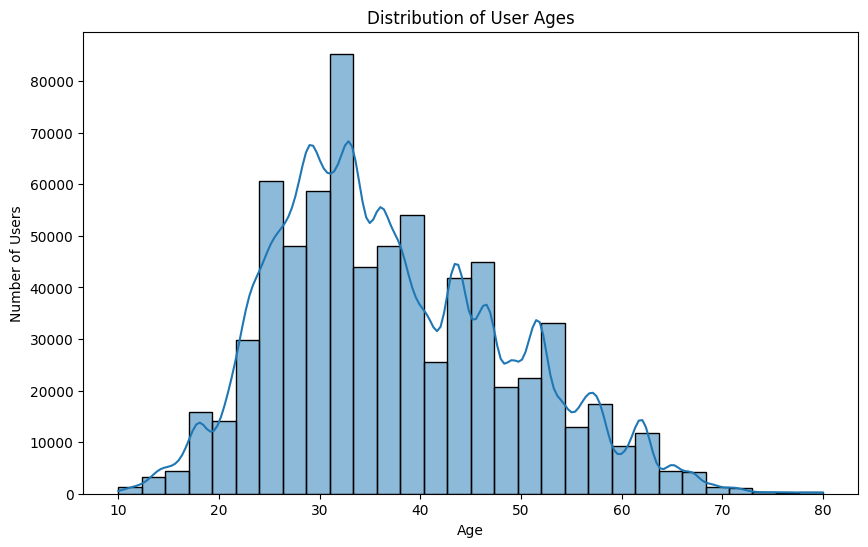

In [27]:
# prompt: draw the plot for the users_filtered

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming users_filtered is a Pandas DataFrame (convert if necessary)
# If users_filtered is a Spark DataFrame, convert it to Pandas:
filtered_users = filtered_users.toPandas()

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(filtered_users['Age'], bins=30, kde=True)  # Adjust bins as needed
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()


# Làm việc với 3 bảng

In [28]:
users_rating_df = filtered_users

##Book table

In [29]:
print(f"Shape of Books DataFrame before potential duplicate removal: {books_df.shape}")
books_df.drop_duplicates(subset='ISBN', keep='first', inplace=True)
print(f"Shape of Books DataFrame after duplicate ISBN removal: {books_df.shape}")

NameError: name 'books_df' is not defined

In [ ]:
print(books_df.head())

##Users_rating table

In [ ]:
users_rating_df.head()


In [ ]:
# Create total data dataframe
total_data_df = pd.merge(users_rating_df, books_df, on='ISBN', how='left', validate='m:m')

# Count ratings per book
book_ratings_count = total_data_df.groupby('ISBN')['Book-Rating'].count()

# Get books with less than 50 ratings
books_to_drop = book_ratings_count[book_ratings_count < 50].index

# Drop books with less than 50 ratings
print(f"\nShape before dropping unpopular books: {total_data_df.shape}")
total_data_df = total_data_df[~total_data_df['ISBN'].isin(books_to_drop)]
print(f"Shape after dropping unpopular books: {total_data_df.shape}")

# Check for NaN values in total_data_df
print("\nNaN values in total_data_df:")
print(total_data_df.isnull().sum())
# Show rows with NaN values
print("\nRows with NaN values:")
print(total_data_df[total_data_df.isnull().any(axis=1)].head())
# Drop NaN values from total_data_df
filtered_data_df = total_data_df.dropna()
print("\nShape after dropping NaN values:", total_data_df.shape)

print(f"Shape after filtering: {filtered_data_df.shape}")
filtered_data_df.head()


# Colaborative filtering


## Matrix Factorization

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer

# Convert to Spark DataFrame
ratings_spark_df = spark.createDataFrame(total_data_df)
ratings_spark_df.printSchema()


In [ ]:

isbn_indexer = StringIndexer(inputCol="ISBN", outputCol="bookId")
ratings_indexed = isbn_indexer.fit(ratings_spark_df).transform(ratings_spark_df)


In [22]:
(training, test) = ratings_indexed.randomSplit([0.8, 0.2], seed=42)


In [23]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# 1. Create the ALS model
als = ALS(
    maxIter=10,
    regParam=0.01,
    rank=10,  # Increased rank for more features
    userCol="User-ID",
    itemCol="bookId",
    ratingCol="implicit_rating",
    coldStartStrategy="drop",
    nonnegative=True,  # Ensures non-negative predictions
    implicitPrefs=True
)



In [24]:
# 2. Define parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [15]) \
    .addGrid(als.regParam, [0.05]) \
    .addGrid(als.maxIter, [15]) \
    .build()

In [25]:
# 3. Define evaluator
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="implicit_rating",
    predictionCol="prediction"
)

In [26]:
# 4. Create CrossValidator
cv = CrossValidator(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=2
)

In [ ]:
# 6. Cache the datasets
training.cache()
test.cache()

# 7. Fit the model using cross-validation
print("Training model with cross-validation...")
cvModel = cv.fit(training)

In [ ]:
# 8. Get the best model
bestModel = cvModel.bestModel

# 9. Print the best parameters
# Print the best parameters
print("\nBest Model Parameters:")
print(f"Rank: {bestModel.rank}")
print("\nAll Model Parameters:")
print(bestModel.explainParams())

In [29]:
# 10. Make predictions on validation set
predictions = bestModel.transform(test)


In [ ]:
# 11. Evaluate final model
rmse = evaluator.evaluate(predictions)
print(f"\nRoot-mean-square error on validation set = {rmse}")

# 12. Show sample predictions
print("\nSample Predictions:")
predictions.select("User-ID", "ISBN", "implicit_rating", "prediction").show(5)


In [ ]:
# Add these debug prints after your predictions
print("Number of rows in predictions:", predictions.count())
print("Sample of predictions:")
predictions.show(5)

# Check for any null values
print("Number of null values in prediction column:", predictions.filter(col("prediction").isNull()).count())
print("Number of null values in Age column:", predictions.filter(col("Age").isNull()).count())

# Check the data types
print("Schema of predictions DataFrame:")
predictions.printSchema()

In [ ]:
# Recommend top 10 books for each user
user_recs = bestModel.recommendForAllUsers(10)
user_recs.show(truncate=False)


In [ ]:
# Assuming you have `books` and `ratings_indexed` Spark DataFrames from the preceding code
# You also need the `isbn_indexer` fitted from the previous step to get the original ISBNs

# Get the mapping from indexed bookId back to original ISBN
# This can be done by accessing the labels from the fitted StringIndexer model
# You need to refit the indexer to get the labels again if the previous fit was not saved
fitted_isbn_indexer = isbn_indexer.fit(ratings_spark_df)
book_id_to_isbn = fitted_isbn_indexer.labels

# Create a Spark DataFrame for the book ID to ISBN mapping
# The index of the label corresponds to the indexed bookId
# Ensure the data type matches the bookId in the recommendations struct (IntegerType)
from pyspark.sql.types import IntegerType
book_id_mapping = spark.createDataFrame([(i, isbn) for i, isbn in enumerate(book_id_to_isbn)], ["bookId", "Original_ISBN"])
book_id_mapping = book_id_mapping.withColumn("bookId", col("bookId").cast(IntegerType())) # Cast to IntegerType

# Now, flatten the recommendations list to join with the main books DataFrame
from pyspark.sql.functions import explode

user_recs_exploded = user_recs.select("User-ID", explode("recommendations").alias("recommendation"))

# Join with the book ID to ISBN mapping
# Access the bookId from the exploded 'recommendation' struct
user_recs_with_isbn = user_recs_exploded.join(book_id_mapping, user_recs_exploded.recommendation.getItem("bookId") == book_id_mapping.bookId, "inner")

# Join with the original books DataFrame to get book details
# Ensure the 'ISBN' column in the 'books' DataFrame is consistent
# Assuming 'ISBN' is the correct column name in your original books Spark DataFrame
book_details_recs = user_recs_with_isbn.join(books, user_recs_with_isbn.Original_ISBN == books.ISBN, "inner")

# Select relevant columns
final_recommendations = book_details_recs.select(
    user_recs_with_isbn["User-ID"],
    user_recs_with_isbn.Original_ISBN.alias("Recommended_ISBN"),
    books["Book-Title"],
    books["Book-Author"],
    user_recs_with_isbn.recommendation.getItem("rating").alias("Estimated_Rating")
)

# Show the final recommendations with book details
final_recommendations.show(truncate=False)

In [ ]:
# Calculate RMSE, Precision@10, Recall@10 based on implicit ratings and predicted ratings
from pyspark.sql.functions import col, explode
from math import sqrt

# Get predictions for all user-item pairs in test data
predictions = bestModel.transform(test)

# Calculate RMSE
rmse = sqrt(predictions.select(
    ((col("implicit_rating") - col("prediction"))**2).alias("squared_error")
).agg({"squared_error": "avg"}).collect()[0][0])

print(f"RMSE: {rmse:.4f}")

# For Precision and Recall, we need to:
# 1. Get top 10 predictions for each user
# 2. Compare with actual implicit ratings

# Get top 10 predictions per user
top_k_predictions = bestModel.recommendForAllUsers(10)
top_k_predictions = top_k_predictions.select(
    col("User-ID"),
    explode("recommendations").alias("recommendation")
).select(
    col("User-ID"),
    col("recommendation.bookId").alias("bookId")
)

# Get actual positive ratings (implicit_rating = 1)
actual_positives = test.filter(col("implicit_rating") == 1)
actual_positives = actual_positives.select("User-ID", "bookId")

# Calculate precision and recall per user
user_metrics = top_k_predictions.join(
    actual_positives.groupBy("User-ID").agg(collect_list("bookId").alias("actual_positives")), 
    "User-ID"
)

def calculate_precision_recall(row):
    predicted = set([row.bookId])
    actual = set(row.actual_positives)
    
    true_positives = len(predicted.intersection(actual))
    precision = true_positives / len(predicted) if len(predicted) > 0 else 0
    recall = true_positives / len(actual) if len(actual) > 0 else 0
    
    return (precision, recall)

metrics = user_metrics.rdd.map(calculate_precision_recall)
avg_precision, avg_recall = metrics.mean()


print(f"Precision@10: {avg_precision:.4f}")
print(f"Recall@10: {avg_recall:.4f}")


In [ ]:
# Create mapping between numeric IDs and ISBNs
# Assuming you have the original mapping from when you created the model
fitted_isbn_indexer = isbn_indexer.fit(ratings_spark_df)
book_id_to_isbn = fitted_isbn_indexer.labels

# Create a reverse mapping (ISBN to numeric ID)
isbn_to_id = {isbn: idx for idx, isbn in enumerate(book_id_to_isbn)}

def get_reranked_recommendations(user_id, current_book_isbn, num_recommendations=10):
    # Convert ISBN to numeric ID
    current_book_id = isbn_to_id.get(current_book_isbn)
    if current_book_id is None:
        print(f"Book ISBN {current_book_isbn} not found in the mapping")
        return None
    print(f"Current book ID: {current_book_id}")
    
    # Step 1: Get initial ALS recommendations
    try:
        user_recs = bestModel.recommendForUserSubset(
            spark.createDataFrame([(user_id,)], ["User-ID"]), 
            num_recommendations
        )
        user_recs = user_recs.collect()
        
        if not user_recs:
            print(f"No recommendations found for user {user_id}")
            return None
        
        # Get recommendations list
        recommendations = user_recs[0].recommendations
        
        # Step 2: Get the current book's features
        current_book_features = None
        for item in bestModel.itemFactors.collect():
            if item.id == current_book_id:
                current_book_features = np.array(item.features)
                break
        if current_book_features is None:
            print(f"Current book ID {current_book_id} not found in the model")
            return None
        
        # Step 3: Calculate similarities and create a list of (ISBN, rating, similarity)
        recommendations_with_similarity = []
        for rec in recommendations:  # Use recommendations instead of user_recs[0].recommendations
            rec_features = None
            for item in bestModel.itemFactors.collect():
                if item.id == rec.bookId:
                    rec_features = np.array(item.features)
                    break
            
            if rec_features is not None:
                # Convert current book features to numpy array if not already
                if not isinstance(current_book_features, np.ndarray):
                    current_book_features = np.array(current_book_features)
                
                # Calculate cosine similarity using numpy
                dot_product = np.dot(current_book_features, rec_features)
                norm_current = np.linalg.norm(current_book_features)
                norm_rec = np.linalg.norm(rec_features)
                similarity = float(dot_product / (norm_current * norm_rec))
                
                # Convert numeric ID back to ISBN for display
                isbn = book_id_to_isbn[rec.bookId]
                recommendations_with_similarity.append((isbn, rec.rating, similarity))
            else:
                print(f"Could not find features for bookId: {rec.bookId}")
        
        if not recommendations_with_similarity:
            print("No similar books found")
            return None
        
        # Step 4: Create DataFrames for recommendations and similarities
        recommendations_df = spark.createDataFrame(
            [(isbn, rating) for isbn, rating, _ in recommendations_with_similarity],
            ["ISBN", "rating"]
        )
        
        similarities_df = spark.createDataFrame(
            [(isbn, similarity) for isbn, _, similarity in recommendations_with_similarity],
            ["ISBN", "Similarity"]
        )
        
        # Step 5: Join with book details and similarities
        book_details_recs = recommendations_df.join(
            books,
            recommendations_df.ISBN == books.ISBN,
            "inner"
        ).join(
            similarities_df,
            recommendations_df.ISBN == similarities_df.ISBN,
            "inner"
        )
        
        # Step 6: Calculate final score (combine ALS rating and similarity)
        als_weight = 0.7
        similarity_weight = 0.3
        
        final_recommendations = book_details_recs.select(
            books["ISBN"],
            books["Book-Title"],
            books["Book-Author"],
            recommendations_df["rating"].alias("ALS_Rating"),
            similarities_df["Similarity"],
            (recommendations_df["rating"] * als_weight + 
             similarities_df["Similarity"] * similarity_weight).alias("Final_Score")
        ).orderBy("Final_Score", ascending=False)
        # Filter recommendations to only include those with similarity > 0.5
        final_recommendations = final_recommendations.filter(
            similarities_df["Similarity"] > 0.3
        )
        return final_recommendations
        
    except Exception as e:
        print(f"Error getting recommendations: {str(e)}")
        return None

In [ ]:
metrics = evaluate_recommendations(bestModel, training, k=10)
print(f"Precision@10: {metrics['precision@k']:.4f}")
f1_score = 2 * (metrics['precision@k'] * metrics['recall@k']) / (metrics['precision@k'] + metrics['recall@k']) if (metrics['precision@k'] + metrics['recall@k']) > 0 else 0
print(f"Recall@10: {metrics['recall@k']:.4f}")
print(f"F1-Score@10: {f1_score:.4f}")

In [ ]:
from pyspark.sql.functions import collect_list
import numpy as np
def calculate_map_ndcg(model, test_data, k=10):
    # Get actual rated books for each user
    user_rated_books = test_data.groupBy("User-ID") \
        .agg(collect_list("bookId").alias("rated_books"))
    
    # Generate recommendations for all users
    # Check if recommendations already exist
    if 'recommendations' in locals():
        pass
    else:
        # Get unique users from test data
        users = test_data.select("User-ID").distinct()
        # Generate recommendations for all users
        recommendations = model.recommendForUserSubset(users, k)
    # Join recommendations with actual ratings
    evaluation_data = recommendations.join(user_rated_books, "User-ID")
    
    def calculate_user_metrics(row):
        # Extract book IDs and scores from recommendations
        recommended = [(r.bookId, r.rating) for r in row.recommendations]
        actual = set(row.rated_books)
        
        # Calculate MAP@K
        ap = 0.0
        hits = 0
        for i, (book_id, _) in enumerate(recommended):
            if book_id in actual:
                hits += 1
                ap += hits / (i + 1)
        map_score = ap / len(actual) if len(actual) > 0 else 0
        
        # Calculate NDCG@K
        # Create ideal ranking (all relevant items first)
        ideal_ranking = [1.0] * len(actual) + [0.0] * (k - len(actual))
        
        # Calculate DCG
        dcg = 0.0
        for i, (book_id, _) in enumerate(recommended):
            if book_id in actual:
                dcg += 1.0 / np.log2(i + 2)  # log2(i+2) because i starts at 0
        
        # Calculate IDCG
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(actual), k)))
        
        # Calculate NDCG
        ndcg = dcg / idcg if idcg > 0 else 0
        
        return (map_score, ndcg)
    
    # Apply the metrics calculation
    metrics = evaluation_data.rdd.map(calculate_user_metrics).collect()
    
    # Calculate average MAP and NDCG
    avg_map = np.mean([m[0] for m in metrics])
    avg_ndcg = np.mean([m[1] for m in metrics])
    
    return {
        "map@k": avg_map,
        "ndcg@k": avg_ndcg
    }

# Calculate and print MAP@K and NDCG@K
map_ndcg_metrics = calculate_map_ndcg(bestModel, training, k=10)
print(f"MAP@10: {map_ndcg_metrics['map@k']:.4f}")
print(f"NDCG@10: {map_ndcg_metrics['ndcg@k']:.4f}")


In [ ]:
filtered_user_ratings.show(5)

In [ ]:
# Create mapping between numeric IDs and ISBNs
# Assuming you have the original mapping from when you created the model
fitted_isbn_indexer = isbn_indexer.fit(ratings_spark_df)
book_id_to_isbn = fitted_isbn_indexer.labels

# Create a reverse mapping (ISBN to numeric ID)
isbn_to_id = {isbn: idx for idx, isbn in enumerate(book_id_to_isbn)}

def get_reranked_recommendations(user_id, current_book_isbn, num_recommendations=10):
    # Convert ISBN to numeric ID
    current_book_id = isbn_to_id.get(current_book_isbn)
    if current_book_id is None:
        print(f"Book ISBN {current_book_isbn} not found in the mapping")
        return None
    print(f"Current book ID: {current_book_id}")
    
    # Step 1: Get initial ALS recommendations
    try:
        user_recs = bestModel.recommendForUserSubset(
            spark.createDataFrame([(user_id,)], ["User-ID"]), 
            num_recommendations
        )
        user_recs = user_recs.collect()
        
        if not user_recs:
            print(f"No recommendations found for user {user_id}")
            return None
        
        # Get recommendations list
        recommendations = user_recs[0].recommendations
        
        # Step 2: Get the current book's features
        current_book_features = None
        for item in bestModel.itemFactors.collect():
            if item.id == current_book_id:
                current_book_features = np.array(item.features)
                break
        if current_book_features is None:
            print(f"Current book ID {current_book_id} not found in the model")
            return None
        
        # Step 3: Calculate similarities and create a list of (ISBN, rating, similarity)
        recommendations_with_similarity = []
        for rec in recommendations:  # Use recommendations instead of user_recs[0].recommendations
            rec_features = None
            for item in bestModel.itemFactors.collect():
                if item.id == rec.bookId:
                    rec_features = np.array(item.features)
                    break
            
            if rec_features is not None:
                # Convert current book features to numpy array if not already
                if not isinstance(current_book_features, np.ndarray):
                    current_book_features = np.array(current_book_features)
                
                # Calculate cosine similarity using numpy
                dot_product = np.dot(current_book_features, rec_features)
                norm_current = np.linalg.norm(current_book_features)
                norm_rec = np.linalg.norm(rec_features)
                similarity = float(dot_product / (norm_current * norm_rec))
                
                # Convert numeric ID back to ISBN for display
                isbn = book_id_to_isbn[rec.bookId]
                recommendations_with_similarity.append((isbn, rec.rating, similarity))
            else:
                print(f"Could not find features for bookId: {rec.bookId}")
        
        if not recommendations_with_similarity:
            print("No similar books found")
            return None
        
        # Step 4: Create DataFrames for recommendations and similarities
        recommendations_df = spark.createDataFrame(
            [(isbn, rating) for isbn, rating, _ in recommendations_with_similarity],
            ["ISBN", "rating"]
        )
        
        similarities_df = spark.createDataFrame(
            [(isbn, similarity) for isbn, _, similarity in recommendations_with_similarity],
            ["ISBN", "Similarity"]
        )
        
        # Step 5: Join with book details and similarities
        book_details_recs = recommendations_df.join(
            books,
            recommendations_df.ISBN == books.ISBN,
            "inner"
        ).join(
            similarities_df,
            recommendations_df.ISBN == similarities_df.ISBN,
            "inner"
        )
        
        # Step 6: Calculate final score (combine ALS rating and similarity)
        als_weight = 0.7
        similarity_weight = 0.3
        
        final_recommendations = book_details_recs.select(
            books["ISBN"],
            books["Book-Title"],
            books["Book-Author"],
            recommendations_df["rating"].alias("ALS_Rating"),
            similarities_df["Similarity"],
            (recommendations_df["rating"] * als_weight + 
             similarities_df["Similarity"] * similarity_weight).alias("Final_Score")
        ).orderBy("Final_Score", ascending=False)
        # Filter recommendations to only include those with similarity > 0.5
        final_recommendations = final_recommendations.filter(
            similarities_df["Similarity"] > 0.3
        )
        return final_recommendations
        
    except Exception as e:
        print(f"Error getting recommendations: {str(e)}")
        return None

In [ ]:
# Get 50 random users and books for testing
random_users = ratings_spark_df.select("User-ID").distinct().limit(5)
random_books = ratings_spark_df.select("ISBN").distinct().limit(5)

# Collect the users and books as lists
user_list = [row["User-ID"] for row in random_users.collect()]
book_list = [row["ISBN"] for row in random_books.collect()]

print("Generating recommendations for 50 users and 50 books...")

# Initialize empty lists to store results
all_recommendations = []

# Generate recommendations for each user-book pair
for user in user_list:
    for book in book_list:
        try:
            # Get recommendations
            recs = get_reranked_recommendations(user, book, num_recommendations=5)
            if recs:
                # Convert to pandas and add source user/book info
                recs_pd = recs.toPandas()
                recs_pd['Source_User'] = user
                recs_pd['Source_Book'] = book
                all_recommendations.append(recs_pd)
                
        except Exception as e:
            print(f"Error getting recommendations for user {user}, book {book}: {str(e)}")
            continue

print("\nFinished generating recommendations")

# Combine all results
if all_recommendations:
    all_recs_df = pd.concat(all_recommendations, ignore_index=True)
    print("\nSample of recommendations:")
    print(all_recs_df.head())
else:
    print("No recommendations were generated successfully")


In [ ]:
print(all_recs_df)

In [73]:
all_recs_df.to_csv("reranked_recommendations.csv", index=False)

In [ ]:
import pickle
pickle.dump(all_recs_df, open('reranked_recommendations.pkl', 'wb'))

### With implicit data